
# Faces dataset decompositions


This example applies to `olivetti_faces_dataset` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
`decompositions`) .


In [1]:
print(__doc__)

# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 clause

import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition
from IPython.display import Markdown

%matplotlib inline

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 4
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
faces = fetch_olivetti_faces(shuffle=True,
                                random_state=rng)
display(Markdown(faces.DESCR))


Automatically created module for IPython interactive environment


.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes                                40
    Samples total                         400
    Dimensionality                       4096
    Features            real, between 0 and 1
    =================   =====================

The image is quantized to 256 grey levels and stored as unsigned 8-bit 
integers; the loader will convert these to floating point values on the 
interval [0, 1], which are easier to work with for many algorithms.

The "target" for this database is an integer from 0 to 39 indicating the
identity of the person pictured; however, with only 10 examples per class, this
relatively small dataset is more interesting from an unsupervised or
semi-supervised perspective.

The original dataset consisted of 92 x 112, while the version available here
consists of 64x64 images.

When using these images, please give credit to AT&T Laboratories Cambridge.


In [2]:
n_samples, n_features = faces.data.shape

# global centering
faces_centered = faces.data - faces.data.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

In [3]:
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

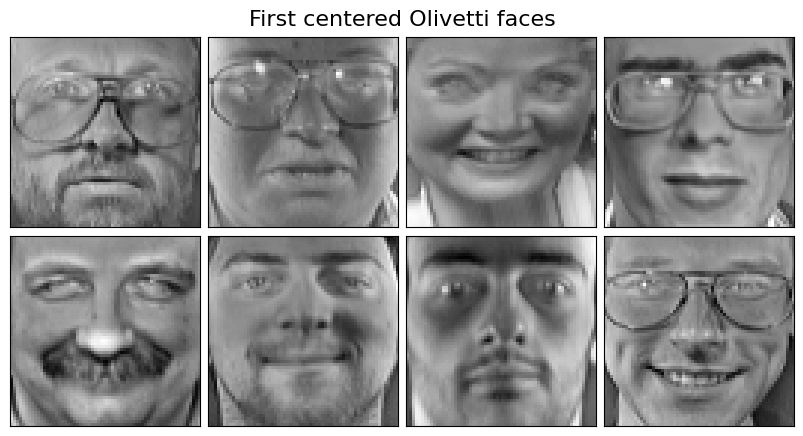

In [4]:
# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# PEC 4

## 1. Comprimir imágenes usando PCA
Preservando 95% de la varianza

Note:
faces = dataBunch
Dictionary-like object, with the following attributes.

data: ndarray, shape (400, 4096)
Each row corresponds to a ravelled face image of original size 64 x 64 pixels.

images: ndarray, shape (400, 64, 64)
Each row is a face image corresponding to one of the 40 subjects of the dataset.

target: ndarray, shape (400,)
Labels associated to each face image. Those labels are ranging from 0-39 and correspond to the Subject IDs.

DESCRstr
Description of the modified Olivetti Faces Dataset.

In [5]:
X = faces.data
y = faces.target

from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) # Preservando 95% de la varianza
X_PCA = pca.fit_transform(X)
print(f'Tras comprimir con PCA quedan: {pca.n_components_} pixeles de los 4096 originales')

Tras comprimir con PCA quedan: 123 pixeles de los 4096 originales


## 2. Comprimir imágenes usando LDA
Se usa el mayor número de componentes posible de: <= min(n_classes - 1, n_features) = <= min(40 - 1, 4096) = 39

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=39)
X_LDA = lda.fit(X, y).transform(X)

## 3. Crear conjuntos de entrenamiento y test
Como hay el mismo número de muestras (10) para todas las clases (40), no hace falta estratificar.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA, y, test_size=0.2, random_state=rng)
X_train_LDA, X_test_LDA, y_train_LDA, y_test_LDA = train_test_split(X_LDA, y, test_size=0.2, random_state=rng)

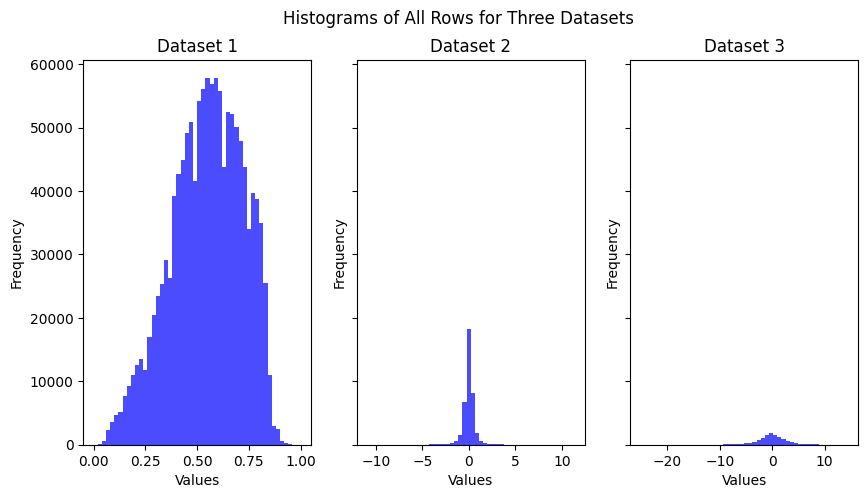

In [8]:
import matplotlib.pyplot as plt

datasets = [X_train, X_train_PCA, X_train_LDA]

# Number of bins in the histogram
num_bins = 50

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

# Plot histograms for each dataset
for i, data in enumerate(datasets):
    flattened_data = data.flatten()
    axs[i].hist(flattened_data, bins=num_bins, color='blue', alpha=0.7)
    axs[i].set_title(f'Dataset {i+1}')
    axs[i].set_xlabel('Values')
    axs[i].set_ylabel('Frequency')

plt.suptitle('Histograms of All Rows for Three Datasets')
plt.show()


Se elige normalizar todos los datos, para que estén en la misma escala, ya que modelos SVM dependen de las distancias de sus características. Por lo que así se promueve una comparación más justa entre modelos.

In [9]:
from sklearn.preprocessing import MinMaxScaler

mm_scaler1 = MinMaxScaler()
X_mm = mm_scaler1.fit_transform(X_train)
mm_scaler2 = MinMaxScaler()
X_PCA_mm = mm_scaler2.fit_transform(X_train_PCA)
mm_scaler3 = MinMaxScaler()
X_LDA_mm = mm_scaler3.fit_transform(X_train_LDA)

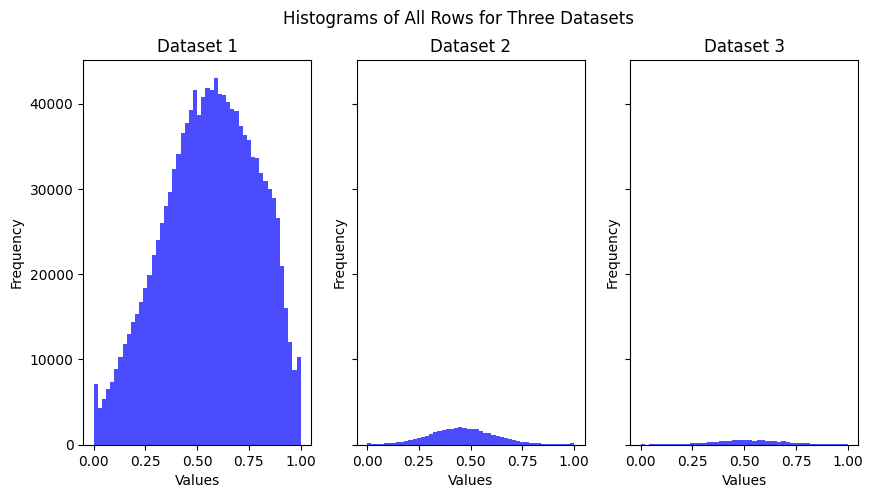

In [10]:
import matplotlib.pyplot as plt

datasets = [X_mm, X_PCA_mm, X_LDA_mm]

# Number of bins in the histogram
num_bins = 50

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

# Plot histograms for each dataset
for i, data in enumerate(datasets):
    flattened_data = data.flatten()
    axs[i].hist(flattened_data, bins=num_bins, color='blue', alpha=0.7)
    axs[i].set_title(f'Dataset {i+1}')
    axs[i].set_xlabel('Values')
    axs[i].set_ylabel('Frequency')

plt.suptitle('Histograms of All Rows for Three Datasets')
plt.show()

Creamos pipeline de preprocesado para escalar los datos. Los datos de cada conjunto tienen dimensiones diferentes (en las columnas). Los originales tienen 4096, PCA tiene 123, y LDA tiene 39.

In [11]:
cols_original = X_train.shape[1]
cols_PCA = X_train_PCA.shape[1]
cols_LDA = X_train_LDA.shape[1]

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

# Pipeline para escalar los vectores de entrada X
pipeline_preprocesado = make_pipeline(MinMaxScaler())

# Aplicando transformaciones al conjunto de datos de entrenamiento
preprocesado = ColumnTransformer([("preprocesado", pipeline_preprocesado, slice(0,cols_original+1))]) # Adding 1 because last index from slice is not taken in Python
preprocesado_PCA = ColumnTransformer([("preprocesado_PCA", pipeline_preprocesado, slice(0,cols_PCA+1))])
preprocesado_LDA = ColumnTransformer([("preprocesado_LDA", pipeline_preprocesado, slice(0,cols_LDA+1))])

A continuación se entrenan los 3 modelos, para los tres tipos de datos de entrada:

In [12]:
# Linear SVC
from sklearn.svm import LinearSVC
clasificador_LinearSVC = Pipeline([('preprocesado', preprocesado), ('linear_svc', LinearSVC(random_state=rng, max_iter=10000, dual='auto'))])
clasificador_LinearSVC.fit(X_train, y_train)

# SVC
from sklearn.svm import SVC
clasificador_SVC = Pipeline([('preprocesado', preprocesado), ('svc', SVC(random_state=rng, kernel='rbf'))])
clasificador_SVC.fit(X_train, y_train)

Pipeline(steps=[('preprocesado',
                 ColumnTransformer(transformers=[('preprocesado',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  slice(0, 4097, None))])),
                ('svc', SVC(random_state=RandomState(MT19937) at 0x108713740))])

In [13]:
# Linear SVC
clasificador_LinearSVC_PCA = Pipeline([('preprocesado_PCA', preprocesado_PCA), ('linear_svc_PCA', LinearSVC(random_state=rng, max_iter=10000, dual='auto'))])
clasificador_LinearSVC_PCA.fit(X_train_PCA, y_train_PCA)

# SVC
clasificador_SVC_PCA = Pipeline([('preprocesado_PCA', preprocesado_PCA), ('svc_PCA', SVC(random_state=rng, kernel='rbf'))])
clasificador_SVC_PCA.fit(X_train_PCA, y_train_PCA)

Pipeline(steps=[('preprocesado_PCA',
                 ColumnTransformer(transformers=[('preprocesado_PCA',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  slice(0, 124, None))])),
                ('svc_PCA',
                 SVC(random_state=RandomState(MT19937) at 0x108713740))])

In [14]:
# Linear SVC
clasificador_LinearSVC_LDA = Pipeline([('preprocesado_LDA', preprocesado_LDA), ('linear_svc_LDA', LinearSVC(random_state=rng, max_iter=10000, dual='auto'))])
clasificador_LinearSVC_LDA.fit(X_train_LDA, y_train_LDA)

# SVC
clasificador_SVC_LDA = Pipeline([('preprocesado_LDA', preprocesado_LDA), ('svc_LDA', SVC(random_state=rng, kernel='rbf'))])
clasificador_SVC_LDA.fit(X_train_LDA, y_train_LDA)

Pipeline(steps=[('preprocesado_LDA',
                 ColumnTransformer(transformers=[('preprocesado_LDA',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  slice(0, 40, None))])),
                ('svc_LDA',
                 SVC(random_state=RandomState(MT19937) at 0x108713740))])

## 4. Afinación de hiperparámetros (datos originales)
*GridSearchCV* con 10 iteraciones

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid_LinearSVC = {'linear_svc__C': [0.0001, 0.01, 1, 100, 10000]}
grid_search_LinearSVC = GridSearchCV(clasificador_LinearSVC, param_grid_LinearSVC, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_LinearSVC.fit(X_train, y_train)

param_grid_SVC = {'svc__C': [0.0001, 0.01, 1, 100, 10000], 'svc__gamma': [0.001, 0.1, 1, 10, 100]}
grid_search_SVC = GridSearchCV(clasificador_SVC, param_grid_SVC, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_SVC.fit(X_train, y_train)

/Users/gregoryturri/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/Users/gregoryturri/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocesado',
                                        ColumnTransformer(transformers=[('preprocesado',
                                                                         Pipeline(steps=[('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         slice(0, 4097, None))])),
                                       ('svc',
                                        SVC(random_state=RandomState(MT19937) at 0x108713740))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.0001, 0.01, 1, 100, 10000],
                         'svc__gamma': [0.001, 0.1, 1, 10, 100]},
             scoring='accuracy')

Elección de los parámetros que dan el mejor modelo de acuerdo a su exactitud y con menor tiempo de ejecución:

In [16]:
import pandas as pd
grid_search_LinearSVC_results = pd.DataFrame(grid_search_LinearSVC.cv_results_)
best_params_LinearSVC = grid_search_LinearSVC_results.loc[grid_search_LinearSVC_results[grid_search_LinearSVC_results.rank_test_score == 1]['mean_fit_time'].idxmin()].to_frame().T

grid_search_SVC_results = pd.DataFrame(grid_search_SVC.cv_results_)
best_params_SVC = grid_search_SVC_results.loc[grid_search_SVC_results[grid_search_SVC_results.rank_test_score == 1]['mean_fit_time'].idxmin()].to_frame().T

In [17]:
print(best_params_LinearSVC.params)
print(best_params_SVC.params)

4    {'linear_svc__C': 10000}
Name: params, dtype: object
15    {'svc__C': 100, 'svc__gamma': 0.001}
Name: params, dtype: object


In [18]:
mejor_clasificador_LinearSVC = Pipeline([('preprocesado', preprocesado), ('linear_svc', LinearSVC(C=10000, random_state=rng, max_iter=10000, dual='auto'))])
mejor_clasificador_LinearSVC.fit(X_train, y_train)

mejor_clasificador_SVC = Pipeline([('preprocesado', preprocesado), ('svc', SVC(C=10000, gamma=0.001, random_state=rng, kernel='rbf'))])
mejor_clasificador_SVC.fit(X_train, y_train)

Pipeline(steps=[('preprocesado',
                 ColumnTransformer(transformers=[('preprocesado',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  slice(0, 4097, None))])),
                ('svc',
                 SVC(C=10000, gamma=0.001,
                     random_state=RandomState(MT19937) at 0x108713740))])

## 5. Afinación de hiperparámetros (datos PCA)
*GridSearchCV* con 10 iteraciones

In [19]:
param_grid_LinearSVC_PCA = {'linear_svc_PCA__C': [0.0001, 0.01, 1, 100, 10000]}
grid_search_LinearSVC_PCA = GridSearchCV(clasificador_LinearSVC_PCA, param_grid_LinearSVC_PCA, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_LinearSVC_PCA.fit(X_train_PCA, y_train_PCA)

param_grid_SVC_PCA = {'svc_PCA__C': [0.0001, 0.01, 1, 100, 10000], 'svc_PCA__gamma': [0.001, 0.1, 1, 10, 100]}
grid_search_SVC_PCA = GridSearchCV(clasificador_SVC_PCA, param_grid_SVC_PCA, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_SVC_PCA.fit(X_train_PCA, y_train_PCA)

/Users/gregoryturri/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(
/Users/gregoryturri/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocesado_PCA',
                                        ColumnTransformer(transformers=[('preprocesado_PCA',
                                                                         Pipeline(steps=[('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         slice(0, 124, None))])),
                                       ('svc_PCA',
                                        SVC(random_state=RandomState(MT19937) at 0x108713740))]),
             n_jobs=-1,
             param_grid={'svc_PCA__C': [0.0001, 0.01, 1, 100, 10000],
                         'svc_PCA__gamma': [0.001, 0.1, 1, 10, 100]},
             scoring='accuracy')

Elección de los parámetros que dan el mejor modelo de acuerdo a su exactitud y con menor tiempo de ejecución:

In [20]:
grid_search_LinearSVC_PCA_results = pd.DataFrame(grid_search_LinearSVC_PCA.cv_results_)
best_params_LinearSVC_PCA = grid_search_LinearSVC_PCA_results.loc[grid_search_LinearSVC_PCA_results[grid_search_LinearSVC_PCA_results.rank_test_score == 1]['mean_fit_time'].idxmin()].to_frame().T

grid_search_SVC_PCA_results = pd.DataFrame(grid_search_SVC_PCA.cv_results_)
best_params_SVC_PCA = grid_search_SVC_PCA_results.loc[grid_search_SVC_PCA_results[grid_search_SVC_PCA_results.rank_test_score == 1]['mean_fit_time'].idxmin()].to_frame().T

In [21]:
print(best_params_LinearSVC_PCA.params)
print(best_params_SVC_PCA.params)

4    {'linear_svc_PCA__C': 10000}
Name: params, dtype: object
21    {'svc_PCA__C': 10000, 'svc_PCA__gamma': 0.1}
Name: params, dtype: object


In [22]:
mejor_clasificador_LinearSVC_PCA = Pipeline([('preprocesado_PCA', preprocesado_PCA), ('linear_svc_PCA', LinearSVC(C=10000, random_state=rng, max_iter=10000, dual='auto'))])
mejor_clasificador_LinearSVC_PCA.fit(X_train_PCA, y_train_PCA)

mejor_clasificador_SVC_PCA = Pipeline([('preprocesado_PCA', preprocesado_PCA), ('svc_PCA', SVC(C=10000, gamma=0.1, random_state=rng, kernel='rbf'))])
mejor_clasificador_SVC_PCA.fit(X_train_PCA, y_train_PCA)

Pipeline(steps=[('preprocesado_PCA',
                 ColumnTransformer(transformers=[('preprocesado_PCA',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  slice(0, 124, None))])),
                ('svc_PCA',
                 SVC(C=10000, gamma=0.1,
                     random_state=RandomState(MT19937) at 0x108713740))])

## 6. Afinación de hiperparámetros (datos LDA)
*GridSearchCV* con 10 iteraciones

In [23]:
param_grid_LinearSVC_LDA = {'linear_svc_LDA__C': [0.0001, 0.01, 1, 100, 10000]}
grid_search_LinearSVC_LDA = GridSearchCV(clasificador_LinearSVC_LDA, param_grid_LinearSVC_LDA, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_LinearSVC_LDA.fit(X_train_LDA, y_train_LDA)

param_grid_SVC_LDA = {'svc_LDA__C': [0.0001, 0.01, 1, 100, 10000], 'svc_LDA__gamma': [0.001, 0.1, 1, 10, 100]}
grid_search_SVC_LDA = GridSearchCV(clasificador_SVC_LDA, param_grid_SVC_LDA, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_SVC_LDA.fit(X_train_LDA, y_train_LDA)

/Users/gregoryturri/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/Users/gregoryturri/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocesado_LDA',
                                        ColumnTransformer(transformers=[('preprocesado_LDA',
                                                                         Pipeline(steps=[('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         slice(0, 40, None))])),
                                       ('svc_LDA',
                                        SVC(random_state=RandomState(MT19937) at 0x108713740))]),
             n_jobs=-1,
             param_grid={'svc_LDA__C': [0.0001, 0.01, 1, 100, 10000],
                         'svc_LDA__gamma': [0.001, 0.1, 1, 10, 100]},
             scoring='accuracy')

Elección de los parámetros que dan el mejor modelo de acuerdo a su exactitud y con menor tiempo de ejecución:

In [24]:
grid_search_LinearSVC_LDA_results = pd.DataFrame(grid_search_LinearSVC_LDA.cv_results_)
best_params_LinearSVC_LDA = grid_search_LinearSVC_LDA_results.loc[grid_search_LinearSVC_LDA_results[grid_search_LinearSVC_LDA_results.rank_test_score == 1]['mean_fit_time'].idxmin()].to_frame().T

grid_search_SVC_LDA_results = pd.DataFrame(grid_search_SVC_LDA.cv_results_)
best_params_SVC_LDA = grid_search_SVC_LDA_results.loc[grid_search_SVC_LDA_results[grid_search_SVC_LDA_results.rank_test_score == 1]['mean_fit_time'].idxmin()].to_frame().T

In [25]:
print(best_params_LinearSVC_LDA.params)
print(best_params_SVC_LDA.params)

1    {'linear_svc_LDA__C': 0.01}
Name: params, dtype: object
16    {'svc_LDA__C': 100, 'svc_LDA__gamma': 0.1}
Name: params, dtype: object


In [31]:
mejor_clasificador_LinearSVC_LDA = Pipeline([('preprocesado_LDA', preprocesado_LDA), ('linear_svc_LDA', LinearSVC(C=0.01, random_state=rng, max_iter=10000, dual='auto'))])
mejor_clasificador_LinearSVC_LDA.fit(X_train_LDA, y_train_LDA)

mejor_clasificador_SVC_LDA = Pipeline([('preprocesado_LDA', preprocesado_LDA), ('svc_LDA', SVC(C=100, gamma=0.1, random_state=rng, kernel='rbf'))])
mejor_clasificador_SVC_LDA.fit(X_train_LDA, y_train_LDA)

Pipeline(steps=[('preprocesado_LDA',
                 ColumnTransformer(transformers=[('preprocesado_LDA',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  slice(0, 40, None))])),
                ('svc_LDA',
                 SVC(C=100, gamma=0.1,
                     random_state=RandomState(MT19937) at 0x108713740))])

## 7. Comparación de modelos
Exactitudes, tiempos de ejecución, medias de los puntajes de los modelos. El número de valores de los parámetros de cada búsqueda es el mismo para cada tipo de clasificador en los 3 tipos de datos de entrada diferentes.

Empezamos con el rendimiento de los modelos: tiempos de ejecución, exactitudes medias de los puntajes de los modelos:

In [32]:
df_best_models_LinearSVC = pd.concat([best_params_LinearSVC, best_params_LinearSVC_PCA, best_params_LinearSVC_LDA], ignore_index=True)
print(f'Tiempos medios de ejecución (ms):{list(df_best_models_LinearSVC.mean_fit_time*1000)}\n',
      f'Exactitudes medias de los puntajes de los modelos:{list( df_best_models_LinearSVC.mean_test_score)}\n')

Tiempos medios de ejecución (ms):[12492.248892784119, 45.509910583496094, 11.378169059753418]
 Exactitudes medias de los puntajes de los modelos:[0.975, 0.96875, 1.0]



Los resultados de los modelos *Linear SVC* son:
* En los datos originales:
  * Tiempo medio de ejecución (ms) = 12314.6
  * Exactitud media = 0.975
* En los datos reducidos mediante PCA:
  * Tiempo medio de ejecución (ms) = 41.8
  * Exactitud media = 0.96875
* En los datos reducidos mediante LDA:
  * Tiempo medio de ejecución (ms) = 12.6
  * Exactitud media = 1

In [33]:
df_best_models_SVC = pd.concat([best_params_SVC, best_params_SVC_PCA, best_params_SVC_LDA], ignore_index=True)
print(f'Tiempos medios de ejecución (ms):{list(df_best_models_SVC.mean_fit_time*1000)}\n',
      f'Exactitudes medias de los puntajes de los modelos:{list( df_best_models_SVC.mean_test_score)}\n')

Tiempos medios de ejecución (ms):[384.503698348999, 20.789551734924316, 7.001042366027832]
 Exactitudes medias de los puntajes de los modelos:[0.96875, 0.95625, 1.0]



Los resultados de los modelos *SVC* son:
* En los datos originales:
  * Tiempo medio de ejecución (ms) = 377.2
  * Exactitud media = 0.96875
* En los datos reducidos mediante PCA:
  * Tiempo medio de ejecución (ms) = 21.2
  * Exactitud media = 0.95625
* En los datos reducidos mediante LDA:
  * Tiempo medio de ejecución (ms) = 7.9
  * Exactitud media = 1

Finalmente calculamos las exactitudes de los 6 modelos en sus respectivos conjuntos de prueba:

In [34]:
y_test_pred_mejor_LinearSVC     = mejor_clasificador_LinearSVC.predict(X_test)
y_test_pred_mejor_LinearSVC_PCA = mejor_clasificador_LinearSVC_PCA.predict(X_test_PCA)
y_test_pred_mejor_LinearSVC_LDA = mejor_clasificador_LinearSVC_LDA.predict(X_test_LDA)
y_test_pred_mejor_SVC     = mejor_clasificador_SVC.predict(X_test)
y_test_pred_mejor_SVC_PCA = mejor_clasificador_SVC_PCA.predict(X_test_PCA)
y_test_pred_mejor_SVC_LDA = mejor_clasificador_SVC_LDA.predict(X_test_LDA)

In [35]:
import sklearn
print(sklearn.metrics.accuracy_score(y_test, y_test_pred_mejor_LinearSVC),
sklearn.metrics.accuracy_score(y_test_PCA, y_test_pred_mejor_LinearSVC_PCA),
sklearn.metrics.accuracy_score(y_test_LDA, y_test_pred_mejor_LinearSVC_LDA),
sklearn.metrics.accuracy_score(y_test, y_test_pred_mejor_SVC),
sklearn.metrics.accuracy_score(y_test_PCA, y_test_pred_mejor_SVC_PCA),
sklearn.metrics.accuracy_score(y_test_LDA, y_test_pred_mejor_SVC_LDA))

0.95 0.95 1.0 0.9375 0.95 1.0


Las exactitudes en los conjuntos de prueba son:
* Modelos Linear SVC:
  * Datos originales = 0.95
  * Datos PCA = 0.95
  * Datos LDA = 1
* Modelos SVC:
  * Datos originales = 0.9375
  * Datos PCA = 0.95
  * Datos LDA = 1

## Conclusiones

* En este proyecto se ponen en práctica muchas de las herramientas aprendidas durante el curso, como preparación de los datos, creación de *pipelines* de estimadores, y cálculo de métricas de interés.
* El objetivo principal es comparar como diferentes técnicas de reducción de dimensionalidad de los datos benefician en el proceso del aprendizaje automático
  * La comparación fundamental se basa en sopesar que es más importante, si tiempo de ejecución o rendimiento del modelo (de acuerdo a la métrica elegida, exactitud en este caso)
* PCA ofrece un método para transformar los datos en un nuevo sistema de coordenadas y así capturar la máxima varianza deseada en un número menor de dimensiones al original (pasando de 4096 a 123 dimensiones en este conjunto de datos para preservar un 95% de la varianza)
* LDA es un método que encuentra combinaciones lineales de las características del conjunto de datos (valores de píxeles en este caso) que separan de la mejor manera 2 o más clases.
* En esta práctica, se puede ver que tras  realizar una búsqueda de red en un conjunto de hiperparámetros de los modelos, el que ofrece los mejores resultados en cuanto a tiempo de ejecución y exactitutd es el de PCA
  * El modelo con los datos de entrada originales (sin reducir su dimensionalidad) tienen un tiempo de ejecución muy elevado, aunque su exactitud es favorable.
  * El modelo que usa LDA tiene el tiempo de ejecución más bajo, y la exacitud más alta (tanto en los conjuntos de entrenamiento como de prueba). Esto puede parecer lo deseable, pero una exactitud del 100% suele indicar un sobre entrenamiento del modelo en los datos.
  * Es por esto que el modelo PCA ofrece el mejor compromiso entre un tiempo de ejecución (rondando decenas de milisegundos), y una exactitud de al menos 95%.
* En cuanto a *LinearSVC* frente a *SVC*, el primero tiene un tiempo de ejecución más elevado por norma general, aunque ofrece una mayor exactitud.
  * Dado que la exactitud no es singificativamente peor para los modelos *SVC*, pero su tiempo de ejecución si es considerablemente menor, estos (*SVC*) efrecen un mejor compromiso